# Sentiment Analysis of Clothes Reviews
I am going to analyze which Machine Learning Algorithm suits best for the prediction of sentiment when we deal with a comparatively small data set. In this notebook I performed a data analysis and data visualization of Clothes Reviews that helped me perform the sentiment analysis. I have ulilized such basic algorithms as Naive Bayes, Dense and Recurrent Neural Networks using Keras in Tensorflow. The highest accuracy achieved is 92.69%. As a result we can see that even easy approaches in ML could be quite effective. 


### Import packages and libraries


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as pex
from wordcloud import WordCloud
from datetime import datetime 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from keras import callbacks

### Read and Explore Data

First, we read the dataframe from csv format and look at it.

In [2]:
df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


We see that there is unnecessary column 'Unnamed: 0'. We need to delete it.



In [3]:
del df['Unnamed: 0']
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


There is a table with 23486 records and 10 features per record. In this dataframe there are different characteristics of customers' reviews. First, we need to perform EDA (Exploratory Data Analysis).

Let's look at missing values.

In [4]:
df.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Some columns have missing values, but we need only Review Text and Rating for the predictions, so we can clean missing values only in these columns. After dropping NA values, we also need to reset index.

In [5]:
df = df.dropna(subset = ['Review Text'])
df = df.reset_index(drop = True)
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
22636,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
22637,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
22638,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
22639,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


As we need only two columns to perform prediction, we will explore them. To do so, we need to look at the distribution of ratings to see if there is any imbalance.

In [6]:
fig = pex.histogram(df, x='Rating')
fig.show()

As we can see, there is a huge imbalance between positive and negative reviews. To overcome it, we need to control for precision, recall, and AUC during and after training.

To look at the popular words in reviews, we will construct the wordcloud.

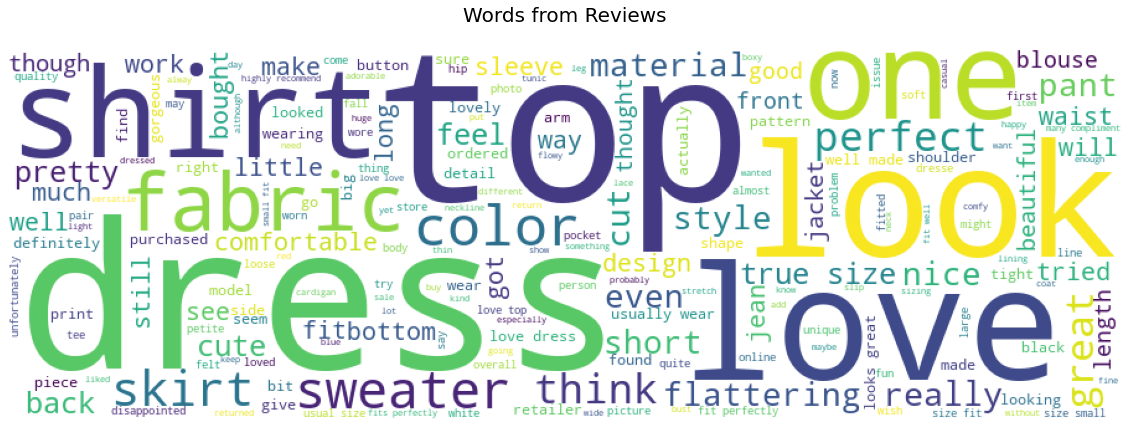

In [7]:
#Data visualization
rev = df['Review Text']

plt.subplots(figsize=(20,12))
wordcloud = WordCloud(background_color='white', width=900, height=300).generate(" ".join(rev))
plt.imshow(wordcloud)
plt.title('Words from Reviews\n',size=20)
plt.axis('off')
plt.show()

### Prepare Data for Prediction

For simplicity we will extract needed columns from the original dataframe into a new one.

In [8]:
df1 = df[['Review Text', 'Rating']]
df1

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
22636,I was very happy to snag this dress at such a ...,5
22637,"It reminds me of maternity clothes. soft, stre...",3
22638,"This fit well, but the top was very see throug...",3
22639,I bought this dress for a wedding i have this ...,3


First, we need to prepare data for binary classification. As we do not need neutral reviews (with Rating 3), we create a new dataframe without them.

In [9]:
df_binary = df1[df1['Rating'] != 3]
df_binary = df_binary.reset_index(drop = True)
df_binary

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,"I love, love, love this jumpsuit. it's fun, fl...",5
3,This shirt is very flattering to all due to th...,5
4,"I love tracy reese dresses, but this one is no...",2
...,...,...
19813,I'm so impressed with the beautiful color comb...,4
19814,I was surprised at the positive reviews for th...,1
19815,So i wasn't sure about ordering this skirt bec...,5
19816,I was very happy to snag this dress at such a ...,5


Now, we need to create a new column with the sentiment (0 for negative sentiment, and 1 for positive sentiment) with the consideration that 1,2 reviews are negative, while 4,5 reviews are positive.

In [10]:
for i in range(len(df_binary)):
  rating = df_binary.loc[i,'Rating']
  if rating >= 4:
    sentiment = 1
  elif rating <= 2:
    sentiment = 0
  df_binary.loc[i, 'Class'] = sentiment
df_binary

,Review Text,Rating,Class
0,Absolutely wonderful - silky and sexy and comf...,4,1.0
1,Love this dress! it's sooo pretty. i happene...,5,1.0
2,"I love, love, love this jumpsuit. it's fun, fl...",5,1.0
3,This shirt is very flattering to all due to th...,5,1.0
4,"I love tracy reese dresses, but this one is no...",2,0.0
...,...,...,...
19813,I'm so impressed with the beautiful color comb...,4,1.0
19814,I was surprised at the positive reviews for th...,1,0.0
19815,So i wasn't sure about ordering this skirt bec...,5,1.0
19816,I was very happy to snag this dress at such a ...,5,1.0


Also, for a multiclass classification we need to create a dataframe with three classes (0 for negative sentiment, and 1 for neutral sentiment, and 2 for positive sentiment).

In [11]:
for i in range(len(df1)):
  rating = df1.loc[i,'Rating']
  if rating >= 4:
    sentiment = 2
  elif rating <= 2:
    sentiment = 0
  elif rating == 3:
    sentiment = 1
  df1.loc[i, 'Class'] = sentiment
df1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Review Text,Rating,Class
0,Absolutely wonderful - silky and sexy and comf...,4,2.0
1,Love this dress! it's sooo pretty. i happene...,5,2.0
2,I had such high hopes for this dress and reall...,3,1.0
3,"I love, love, love this jumpsuit. it's fun, fl...",5,2.0
4,This shirt is very flattering to all due to th...,5,2.0
...,...,...,...
22636,I was very happy to snag this dress at such a ...,5,2.0
22637,"It reminds me of maternity clothes. soft, stre...",3,1.0
22638,"This fit well, but the top was very see throug...",3,1.0
22639,I bought this dress for a wedding i have this ...,3,1.0


## 1st Problem: Binary Classification

### Naive Bayes


#### Data Preparation

To store the review sequences for basic ML algorithm, we will use TFidfVectorizer.

In [12]:
vectorizer = TfidfVectorizer()

We create X (features) and Y (class) vectors to feed the vectorizer.

In [13]:
X = df_binary['Review Text'].values
Y = df_binary['Class'].values

Now, we divide the data into test and train datasets. We use 20% of the data as test. We use random state parameter to make the work reproducible.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1145)


Now,  we can train the vectorizer on the train data and transorm both train and test data into Tfidf matrix.

In [15]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### Model creation and analysis

We create and train Naive Bayes model to predict sentiment.

In [16]:
model = MultinomialNB()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

To look at the performance of the model, we can use classification report function.

In [17]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       493
         1.0       0.88      1.00      0.93      3471

    accuracy                           0.88      3964
   macro avg       0.94      0.50      0.47      3964
weighted avg       0.89      0.88      0.82      3964



The recall is extremely bad (which means that model predicts no negative reviews), so the model is inaccurate. As the classic machine learning algorithm does not work, we need to implement neural network. 

### Neural Networks

#### Data Preparation

Create two vectors for X (features) and for Y (labels) which is a convention among data scientists. Add *.values* at the end of the declaration to transform the dataframe or series into a numpy array.

In [18]:
X = df_binary['Review Text'].values
Y = df_binary['Class'].values

Now, we divide the data into test and train datasets. We use 20% of the data as test. We use random state parameter to make the work reproducible.

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1145)

To prepare text data to be fed into Neural Network, we need to tokenize it and transform it into dense (fully connected) matrix. In this Neural Network every perceptron is connected to one another. It is more appropriate to use dense matrix than sparse matrix, because Neural Networks do not like missing values (such as zeros in sparse matrix). 

To perform the transformation, we need to define a few parameters:

- **max_words** - maximum number of words in the dictionary (which are considered important)

- **max_len** - maximum length of word in the dictionary

In [20]:
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

#### Recurrent NN with LSTM

First, we will implement Reccurent Neural Network with LSTM layers to fit the data. Recurrent Neural Networks are more suitable for the purpose of text analytics because they have memory in every unit on every layer, which can capture the patterns in the sentences as sequences.


In [21]:
model1 = Sequential()

model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(40, dropout=0.5))
model1.add(layers.Dense(1, activation = 'sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 209,801
Trainable params: 209,801
Non-trainable params: 0
_________________________________________________________________


The model needs to be compiled. We define some parameters in the *compile* method:

- **adam** - the widely used optimizer

- **binary_crossentropy** - the loss function always used for binary classification

- **accuracy** - important metric to control for during training and testing

In [22]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','AUC'])

To optimize training, we define a callback which will stop train the model if the test loss will increase during epochs. Parameter restore_best_weights will help us to save the best version of the model before it starts overfitting.

In [23]:
callback = [callbacks.EarlyStopping(patience = 2, restore_best_weights=True)]

Now we can train the model using *fit* method. In it we define training data and labels, number of epochs (number of times the neural network sees the whole training dataset), validation (or test) data, callbacks, and batch_size (how many reviews will go into the neural network at once).

In [24]:
model1.fit(X_train, Y_train, epochs = 15, validation_data=(X_test,Y_test), callbacks=callback, batch_size = 1024)

Epoch 1/15
16/16 [==============================] - 20s 1s/step - loss: 0.6632 - accuracy: 0.7853 - auc: 0.5227 - val_loss: 0.4505 - val_accuracy: 0.8756 - val_auc: 0.6784
Epoch 2/15
16/16 [==============================] - 15s 952ms/step - loss: 0.3974 - accuracy: 0.8780 - auc: 0.5511 - val_loss: 0.3698 - val_accuracy: 0.8756 - val_auc: 0.8301
Epoch 3/15
16/16 [==============================] - 15s 951ms/step - loss: 0.3551 - accuracy: 0.8826 - auc: 0.7587 - val_loss: 0.3622 - val_accuracy: 0.8756 - val_auc: 0.8748
Epoch 4/15
16/16 [==============================] - 15s 947ms/step - loss: 0.3529 - accuracy: 0.8775 - auc: 0.8382 - val_loss: 0.3447 - val_accuracy: 0.8756 - val_auc: 0.8980
Epoch 5/15
16/16 [==============================] - 15s 948ms/step - loss: 0.3225 - accuracy: 0.8825 - auc: 0.9086 - val_loss: 0.3102 - val_accuracy: 0.8756 - val_auc: 0.9110
Epoch 6/15
16/16 [==============================] - 15s 963ms/step - loss: 0.2764 - accuracy: 0.8835 - auc: 0.9261 - val_loss: 0

To assess the performance of the model, we predict labels for the test dataset and create a classification report.

In [25]:
Y_pred = model1.predict_classes(X_test)

print(classification_report(Y_test, Y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

         0.0       0.74      0.69      0.71       493
         1.0       0.96      0.97      0.96      3471

    accuracy                           0.93      3964
   macro avg       0.85      0.83      0.84      3964
weighted avg       0.93      0.93      0.93      3964



#### Recurrent NN with GRU

In addition to Recurrent Neural Network with LSTM, we will try another Recurretn Neural Network with GRU. Sometimes it can give us increase in accuracy due to specific features of the data.

In [26]:
model2 = Sequential()

model2.add(layers.Embedding(max_words, 20))
model2.add(layers.GRU(40, dropout=0.2, return_sequences=True))
model2.add(layers.GRU(10, dropout=0.2))
model2.add(layers.Dense(1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
gru (GRU)                    (None, None, 40)          7440      
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 209,011
Trainable params: 209,011
Non-trainable params: 0
_________________________________________________________________


The model is to be compiled. We define some parameters in the *compile* method:

- **adam** - the widely used optimizer

- **binary_crossentropy** - the loss function always used for binary classification

- **accuracy** - important metric to control for during training and testing

In [27]:
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC'])

To optimize training, we define a callback which will stop train the model if the test loss will increase during epochs. Parameter restore_best_weights will help us to save the best version of the model before it starts overfitting.

In [28]:
callback = [callbacks.EarlyStopping(patience = 2, restore_best_weights=True)]

Now we can train the model using *fit* method. In it we define training data and labels, number of epochs (number of times the neural network sees the whole training dataset), validation (or test) data, callbacks, and batch_size (how many reviews will go into the neural network at once).

In [29]:
history = model2.fit(X_train, Y_train, epochs = 15, validation_data=(X_test,Y_test), callbacks=callback, batch_size = 1024)

Epoch 1/15
16/16 [==============================] - 25s 1s/step - loss: 0.6597 - accuracy: 0.8088 - auc: 0.4976 - val_loss: 0.5145 - val_accuracy: 0.8756 - val_auc: 0.6239
Epoch 2/15
16/16 [==============================] - 20s 1s/step - loss: 0.4471 - accuracy: 0.8812 - auc: 0.5370 - val_loss: 0.3870 - val_accuracy: 0.8756 - val_auc: 0.6797
Epoch 3/15
16/16 [==============================] - 20s 1s/step - loss: 0.3738 - accuracy: 0.8794 - auc: 0.6136 - val_loss: 0.3671 - val_accuracy: 0.8756 - val_auc: 0.8251
Epoch 4/15
16/16 [==============================] - 20s 1s/step - loss: 0.3486 - accuracy: 0.8834 - auc: 0.8015 - val_loss: 0.3580 - val_accuracy: 0.8756 - val_auc: 0.8468
Epoch 5/15
16/16 [==============================] - 20s 1s/step - loss: 0.3394 - accuracy: 0.8823 - auc: 0.8668 - val_loss: 0.3403 - val_accuracy: 0.8756 - val_auc: 0.8519
Epoch 6/15
16/16 [==============================] - 20s 1s/step - loss: 0.3204 - accuracy: 0.8803 - auc: 0.8785 - val_loss: 0.3082 - val_acc

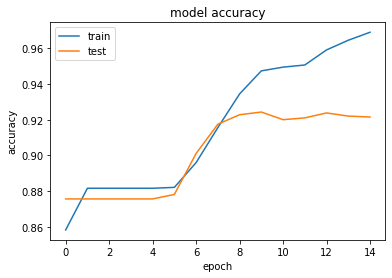

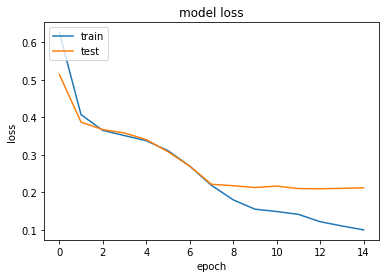

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

To assess the performance of the model, we predict labels for the test dataset and create a classification report.

In [31]:
Y_pred = model2.predict_classes(X_test)

print(classification_report(Y_test, Y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

         0.0       0.72      0.64      0.68       493
         1.0       0.95      0.96      0.96      3471

    accuracy                           0.92      3964
   macro avg       0.83      0.80      0.82      3964
weighted avg       0.92      0.92      0.92      3964



### Discussion of Results

Both Neural Networks provide a reliable and accurate predictions with accuracy around 92%. However, the recall of class 0 in both of them is around 66%, which means they work worse to predict negative reviews than positive reviews. 

We can possibly enhance the results with the custom learning rate or other additions.

### Multiclass classification with Recurrent Neural Network

#### Data Preparation

Create two vectors for X (features) and for Y (labels) which is a convention among data scientists. Add .values at the end of the declaration of X to transform the dataframe or series into a numpy array. For Y we do not need numpy array yet, because we will do some transformation in the next cell.

In [32]:
X = df1['Review Text'].values
Y = df1['Class']

As we do multiclass classification, we need to give probabilities of being in every existing class for every record. For this purpose, we create a one-hot encoding using *get_dummies* function. After that, we transform the resulting dataset to a numpy array.

In [33]:
Y = pd.get_dummies(Y)
Y = Y.values
Y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

We divide the data into test and train datasets again for the new multiclass classification. We use 20% of the data as test and a random state parameter to make the work reproducible.

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1145)

To prepare text data to be fed into Neural Network, we need to tokenize it and transform it into dense (fully connected) matrix. In this Neural Network every perceptron is connected to one another. It is more appropriate to use dense matrix than sparse matrix, because Neural Networks do not like missing values (such as zeros in sparse matrix). 

To perform the transformation, we need to define a few parameters:

- **max_words** - maximum number of words in the dictionary (which are considered important)

- **max_len** - maximum length of word in the dictionary

In [35]:
max_words = 10000
max_len = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

#### Recurrent NN with GRU

Here, we defined the Reccurent Neural Network with GRU. We use embedding layer to transform the words matrix into appropriate NN input, then we use three GRU layers with dropout to ensure the unbiased classification, and then we create a dense layer to output the results.

In [36]:
model3 = Sequential()

model3.add(layers.Embedding(max_words, 20))
model3.add(layers.GRU(50, dropout=0.3, return_sequences=True))
model3.add(layers.GRU(30, dropout=0.2, return_sequences=True))
model3.add(layers.GRU(10, dropout=0.1))
model3.add(layers.Dense(3, activation = 'softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 50)          10800     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 30)          7380      
_________________________________________________________________
gru_4 (GRU)                  (None, 10)                1260      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 219,473
Trainable params: 219,473
Non-trainable params: 0
_________________________________________________________________


In [37]:
model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'AUC'])

In [38]:
callback = [callbacks.EarlyStopping(restore_best_weights=True)]

In [39]:
model3.fit(X_train, Y_train, epochs = 15, validation_data=(X_test,Y_test), callbacks=callback, batch_size = 1024)

Epoch 1/15
18/18 [==============================] - 12s 366ms/step - loss: 1.0140 - accuracy: 0.6835 - auc: 0.7935 - val_loss: 0.7096 - val_accuracy: 0.7620 - val_auc: 0.8528
Epoch 2/15
18/18 [==============================] - 5s 262ms/step - loss: 0.6949 - accuracy: 0.7758 - auc: 0.8465 - val_loss: 0.7011 - val_accuracy: 0.7620 - val_auc: 0.8836
Epoch 3/15
18/18 [==============================] - 5s 261ms/step - loss: 0.6827 - accuracy: 0.7705 - auc: 0.8841 - val_loss: 0.6827 - val_accuracy: 0.7620 - val_auc: 0.8990
Epoch 4/15
18/18 [==============================] - 5s 262ms/step - loss: 0.6397 - accuracy: 0.7765 - auc: 0.9097 - val_loss: 0.6245 - val_accuracy: 0.7633 - val_auc: 0.9097
Epoch 5/15
18/18 [==============================] - 5s 263ms/step - loss: 0.5776 - accuracy: 0.7763 - auc: 0.9209 - val_loss: 0.5608 - val_accuracy: 0.7801 - val_auc: 0.9182
Epoch 6/15
18/18 [==============================] - 5s 263ms/step - loss: 0.5038 - accuracy: 0.7942 - auc: 0.9343 - val_loss: 0.5

Because we need to have a list of labels to perform a creation of classification report, we need to redefine Y_test which is now a 2-dimensional matrix.



In [40]:
Y1 = df1['Class']
X_train1, X_test1, Y_train1, Y_test = train_test_split(X,Y1, test_size = 0.2, random_state = 1145)

To assess the performance of the model, we predict labels for the test dataset and create a classification report.

In [41]:
Y_pred = model3.predict_classes(X_test)
target_names = ['negative', 'neutral', 'positive']

print(classification_report(Y_test, Y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

    negative       0.46      0.48      0.47       508
     neutral       0.27      0.06      0.10       570
    positive       0.85      0.95      0.90      3451

    accuracy                           0.79      4529
   macro avg       0.53      0.50      0.49      4529
weighted avg       0.73      0.79      0.75      4529



#### Discussion of Results

The neural network has the accuracy around 78%, but the recall for negative and especially neutral reviews is low. It can be caused by the difficulty of identifying 'neutral' words and the lengths of reviews can be too short to correctly identify this type of reviews.

#### Predictions

We are going to test all models on the real reviews taken from https://www.michaelkors.com/.


In [42]:
t = pd.read_csv('/content/Michael Kors clothes reviews.csv').dropna()
t

,Text,Label
0,This was a mother's day gift I received . Very...,positive
1,"With the birthday coupon, I got this bag in an...",positive
2,Color not as smooth as expected not a rich blu...,negative
3,When I received this bag I knew I didn’t like ...,negative
4,Purchased this jumpsuit today. It is gorgeous!...,positive
5,I bought it from store but for me this bag is ...,neutral
6,"I really love the quilted leather, but the gol...",neutral
7,I'm very disappointed from my purchase . It's ...,negative
8,I was so excited for this crossbody purse. It’...,negative
9,I received this purse yesterday and as much as...,negative


We have built a function that takes the text of the reviews, the number of the model and the given estimation label as arguments and outputs the predicted value for each model.

In [43]:
def check_model_on_text(text, model, label):
  sequences = tokenizer.texts_to_sequences([text])
  seq = pad_sequences(sequences, maxlen=max_len)
  if model == 1:
    print('probability of positive review', model1.predict(seq)[0][0])
    print('real label:', label)
  elif model == 2:
    print('probability of positive review', model2.predict(seq)[0][0])
    print('real label:', label)
  elif model == 3:
    print('probability of negative review', model3.predict(seq)[0][0])
    print('probability of neutral review', model3.predict(seq)[0][1])
    print('probability of positive review', model3.predict(seq)[0][2])
    print('real label:', label)
  
for j in range (0,14):
  print('Predicted review number', j)
  for i in range(1,4):  
    check_model_on_text(t.loc[j, 'Text'], i, t.loc[j, 'Label'])


Predicted review number 0
probability of positive review 0.62812793
real label: positive
probability of positive review 0.8873576
real label: positive
probability of negative review 0.0039343867
probability of neutral review 0.0096173845
probability of positive review 0.9864482
real label: positive
Predicted review number 1
probability of positive review 0.99699223
real label: positive
probability of positive review 0.98236793
real label: positive
probability of negative review 0.005649657
probability of neutral review 0.017225215
probability of positive review 0.97712517
real label: positive
Predicted review number 2
probability of positive review 0.914688
real label: negative
probability of positive review 0.97158456
real label: negative
probability of negative review 0.4537214
probability of neutral review 0.38031477
probability of positive review 0.16596389
real label: negative
Predicted review number 3
probability of positive review 0.9902178
real label: negative
probability of po

As we can see the best accuracy is achieved with positive reviews in all three models. This is due to the fact that there is the greatest amount of such reviews in the dataset while the number of negative ones is significantly lower and neutral is the smallest group which is hard to predict because it is quite vague. For example, we can see that in review number 10 all three models predict high percent of positive label although the review is actually negative. However, this information could be misinterpreted by a human as well as the wording is quite elusive as it does not contain any strong negative evaluation: "I received this purse yesterday and as much as I want to love it, it had scratches on the leather. The leather is easily scratched and it felt like I received a damaged or returned product plus it’s so tiny!"
With neutral reviews the situation is quite similar as we can see reviews number five and six: "I bought it from store but for me this bag is small for using" and "I really love the quilted leather, but the gold hardware gets scratched ao easily and it is imposible to remove. I would chexk ot out in store dorst" are quite prejudiced and could be easily misinterpreted especially with typos in the sixth review.